## Basic Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler





## Cleaning

In [ ]:
csv_file_path = 'clean_merged_playerdata_with_weather.csv'

df = pd.read_csv(csv_file_path)

# drop columns we definitely don't need
df = df.drop(["bet_type", "tie_rule", "open_time", "close_time", 
              "p1_outcome_text", "p2_outcome_text", "p3_outcome_text", 
              "book", "event_completed", "event_name", "odds", 
             
             'p1_player_name', 'p2_player_name', 'p3_player_name',
             
             'dg_id_p1', 'fin_text_p1', 'fin_text_p2', 'fin_text_p3',
             'course_name_p1', 'teetime_p2', 'teetime_p3', 'wx_teetime',
             'wx_datetime_hour',
             'wx_date_from_close', 'wx_conditions', 'wx_icon', 'wx_datetimeEpoch',
             'tour_p1', 'season'], axis=1)

# rename columns we'd like to keep
df = df.rename(columns={'teetime_p1':'teetime'})

df = df.drop(["teetime"], axis=1)


# preciptype can either only be nan or 'rain'
df['wx_preciptype'] = df['wx_preciptype'].fillna(0)
df['wx_preciptype'] = df['wx_preciptype'].apply(lambda x: 1 if x != 0 else x)
    
    

# Create one outcome column
df['outcome'] = (
    df[['p1_outcome', 'p2_outcome', 'p3_outcome']]
    .fillna(0) # turn all na's or NaNs to 0
    .idxmax(axis=1) 
    .str.extract(r'p(\d+)_outcome') # pull out 1, 2, 3
    .astype(float) # convert to floats
)
# Then remove the other outcome column
df = df.drop(['p1_outcome', 'p2_outcome', 'p3_outcome'], axis=1)


C:\Users\Olive\AppData\Local\Temp\ipykernel_31560\2511794079.py:3: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


In [19]:
# create a csv to check changes
df.to_csv('cleaned_golf.csv', index=False)

## PCA

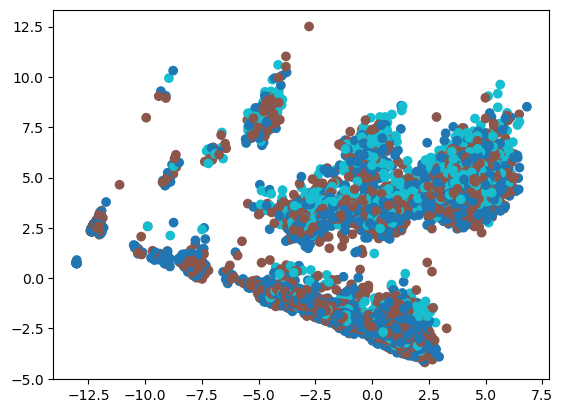

Var:  [0.22360463 0.12560599 0.04810707 0.04290873 0.0380338  0.03737078
 0.03093624 0.02541193 0.01868722 0.01703262]


In [27]:
df_copy = df.copy()
df_copy = df_copy.drop(["outcome"], axis=1)

pd.set_option("display.max_columns", None)

df_copy = df_copy.select_dtypes(include=['number'])
df_copy = df_copy.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_copy)

pca = PCA(n_components=10)
transformed_data = pca.fit_transform(X_scaled)

plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=df["outcome"], cmap="tab10")
plt.show()

print("Var: ", pca.explained_variance_ratio_)

## Correlation Matrix

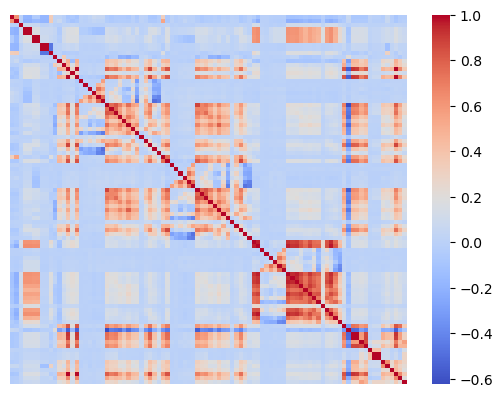

In [28]:
cor = df_copy.corr()
import seaborn as sns

sns.heatmap(cor, xticklabels=False, yticklabels=False, cmap='coolwarm')
plt.show()

## Train Test Split - Preliminary Accuracy of RandomForestClassifier

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df, df['outcome'], test_size=0.25, random_state=0)

print("Training x:", x_train.shape,"y:", y_train.shape)
print("Testing x:", x_test.shape,"y:", y_test.shape)


# This takes ~20 sec to run because there's so much data.
RandomForestClassifier().fit(x_train, y_train).score(x_test, y_test)

Training x: (32163, 93) y: (32163,)
Testing x: (10721, 93) y: (10721,)


0.9995336255946273

## Finding Scores For n_estimators

0.9917918104654416
0.9965488294002425
0.9990672511892548
0.9993470758324783
0.9995336255946273
0.9995336255946273
0.9995336255946273
0.9996269004757019
0.9997201753567764
0.9996269004757019
0.9994403507135529
0.9997201753567764
0.9997201753567764
0.9997201753567764
0.9997201753567764
0.999813450237851
0.9997201753567764
0.999813450237851
0.9997201753567764


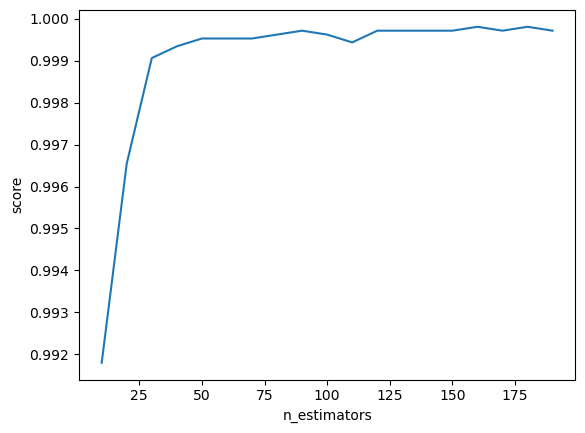

In [31]:
# This takes forever (like 10 min?) -> don't run it
# Prob adjust to use PCA data if we want to try graphing our scores like this
scores = []
for i in range(10, 200, 10):
    score_i = RandomForestClassifier(n_estimators=i).fit(x_train, y_train).score(x_test, y_test)
    print(score_i)
    scores.append(score_i)
plt.plot(range(10, 200, 10), scores)
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.show()